# Preprocessing Images

In [1]:
import cv2
import os
import shutil
import random
import pandas
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Convolution2D as Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

##### Creating Image Files Array from a provided directory

In [ ]:
def create_image_files_array(image_directory):
  # Array to hold all the image files
  image_files = []

  # Looping through all the images in the directory
  for image in os.listdir(image_directory) :
    if image.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')): # Checking if the file is of any image type
      image_files.append(image) # Adding the image to the array
  return image_files

##### Loading Images and Labels from a folder into two seperate folders

In [ ]:
def load_images_and_labels(data_folder):
    images = []
    labels = []

    for label in os.listdir(data_folder):
        label_folder = os.path.join(data_folder, label)
        for image_name in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_name)
            images.append(image_path)
            labels.append(label)

    return images, labels

##### To count the items in the directory

In [ ]:
# Function to count the number of images in a directory
def count_images(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

##### Reading the images

In [2]:
cataract_dataset_path = "D:\\Final Year\\FYP\\Code\\Dataset\\Binary"
cataract_severity_dataset_path = "D:\\Final Year\\FYP\\Code\\Dataset\\Severity Classified"
cataract_type_dataset_path = "D:\\Final Year\\FYP\\Code\\Dataset\\Types Classified"

##### Resize Images

In [ ]:
def resize_images(image, image_path, image_resize_threshold) :
    try:
        if image.shape[1] > image_resize_threshold :

            # Calculate the percentage to scale the image
            scale_percentage = image_resize_threshold / image.shape[1] * 100

            # Calculate the new dimensions while maintaining the aspect ratio
            new_width  = int((image.shape[1] * scale_percentage) /100)
            new_height = int((image.shape[0] * scale_percentage) /100)
            new_dimensions = (new_width, new_height)

            # Resizing the image using OpenCV
            resized_image = cv2.resize(
                image,
                new_dimensions,
                interpolation=cv2.INTER_AREA
            )
            cv2.imwrite(image_path, resized_image)
            image_path = cv2.imread(image_path)

        return image
    except Exception as exception:
        print(f"Error processing : {str(exception)}")

##### Convert Image to Grey Scale

In [ ]:
# Remove the colors from the image resulting a grey scale image
def grey_scale_image(image):
    grey_scale_image = cv2.cvtColor(
        image,
        cv2.COLOR_BGR2GRAY
    )
    return grey_scale_image

##### Enhance Image

In [ ]:
def enhance_image(image) :
  return cv2.equalizeHist(image)

##### Normalise the Image

In [ ]:
# The Min Max Scaler Normalisation technique is used to noramlise the image
def normalise_image(image):
    normalized_image = cv2.normalize(
        image, None,
        0,
        1.0,
        cv2.NORM_MINMAX,
        dtype=cv2.CV_32F
    )
    normalized_image *= 255
    return normalized_image

##### Remove Noise from the Image

In [ ]:
def noise_reduction(image):
    noise_reduction_image = cv2.GaussianBlur(
        image,
        (5, 5),
        0
    )
    return noise_reduction_image

##### Detect Edges in the Image

In [ ]:
def edge_detection(image):
    # Apply the horizontal and vertical Prewitt operators
    prewitt_x = cv2.filter2D(image, cv2.CV_32F, np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]))
    prewitt_y = cv2.filter2D(image, cv2.CV_32F, np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]))

    # Compute the magnitude of the gradient
    gradient_magnitude = np.sqrt(prewitt_x**2 + prewitt_y**2)
    return gradient_magnitude

##### Preprocess Method

In [118]:
def preprocess_image(image, image_path,  image_resize_threshold = 300) :
    try:
        image = resize_images(image, image_path,  image_resize_threshold)  # Resizing Image
        image = grey_scale_image(image)                                    # Grey Scale Image
        image = enhance_image(image)                                       # Enhance Image
        image = normalise_image(image)
        image = noise_reduction(image)
        image = edge_detection(image)
        plt.imshow(image, cmap='gray')
        return image
    except Exception as exception:
        print(f"Error processing : {str(exception)}")

Resizing Cataract & Normal Images

In [ ]:
cataract_dataset_folder_paths = []
for folder in os.listdir(cataract_dataset_path):
    if os.path.isdir(os.path.join(cataract_dataset_path, folder)):
        cataract_dataset_folder_paths.append(os.path.join(cataract_dataset_path, folder))


for folder in cataract_dataset_folder_paths: 
    # Generate the image files array
    image_files_array = create_image_files_array(folder)
    
    for image_file in image_files_array :
        file_path = os.path.join(folder, image_file) # Generating the file path for each image
        image = cv2.imread(file_path)                # Reading the image
        if image is not None :                       # Checking if image is not None attribute
            image = preprocess_image(image, file_path)
            cv2.imwrite(file_path, image)

# Binary Classification

In [34]:
cataract_train_path      = "D:\\Final Year\\FYP\\Code\\Dataset\\Binary Split\\train"
cataract_test_path       = "D:\\Final Year\\FYP\\Code\\Dataset\\Binary Split\\test"
cataract_validation_path = "D:\\Final Year\\FYP\\Code\\Dataset\\Binary Split\\validation"

In [ ]:
# Create directories if they don't exist
if not os.path.exists(cataract_train_path):
    os.makedirs(cataract_train_path)
if not os.path.exists(cataract_test_path):
    os.makedirs(cataract_test_path)
if not os.path.exists(cataract_validation_path):
    os.makedirs(cataract_validation_path)

# List all class folders
class_folders = os.listdir(cataract_dataset_path)

# Iterate through each class folder
for folder in class_folders:
    class_dir = os.path.join(cataract_dataset_path, folder)
    
    # List all image filenames in the class folder
    image_filenames = os.listdir(class_dir)
    
    # Split the dataset for each class into train, test, and validation sets
    train_files, test_val_files = train_test_split(image_filenames, test_size=0.3, random_state=42)
    test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)
    
    # Move images to their respective directories
    def move_files(files, destination_dir):
        for filename in files:
            src_path = os.path.join(class_dir, filename)
            dst_path = os.path.join(destination_dir, folder, filename)
            if not os.path.exists(os.path.join(destination_dir, folder)):
                os.makedirs(os.path.join(destination_dir, folder))
            shutil.copy(src_path, dst_path)
        
    move_files(train_files, cataract_train_path)
    move_files(test_files,  cataract_test_path)
    move_files(val_files,   cataract_validation_path)

In [35]:
# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

cataract_train_generator = train_datagen.flow_from_directory(
    cataract_train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

cataract_validation_generator = test_datagen.flow_from_directory(
   cataract_validation_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

cataract_test_generator = test_datagen.flow_from_directory(
    cataract_test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 6024 images belonging to 2 classes.
Found 1292 images belonging to 2 classes.
Found 1291 images belonging to 2 classes.


In [ ]:
# Define the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))  

# Compile the model with ADAM optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    cataract_train_generator,
    steps_per_epoch=cataract_train_generator.samples // cataract_train_generator.batch_size,
    epochs=3,
    validation_data=cataract_validation_generator,
    validation_steps=cataract_validation_generator.samples // cataract_validation_generator.batch_size
)

# Evaluate the model using the testing data
test_loss, test_accuracy = model.evaluate(cataract_test_generator, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
model.save("cataractdetectionmodel.h5")
# Get the model summary
model.summary()

# Severity Assessment 
## Multiclass Classification

##### Split the Dataset

In [4]:
cataract_severity_train_path      = "D:\\Final Year\\FYP\\Code\\Dataset\\Severity Classified Split\\train"
cataract_severity_test_path       = "D:\\Final Year\\FYP\\Code\\Dataset\\Severity Classified Split\\test"
cataract_severity_validation_path = "D:\\Final Year\\FYP\\Code\\Dataset\\Severity Classified Split\\validation"

In [ ]:
# Create directories if they don't exist
if not os.path.exists(cataract_severity_train_path):
    os.makedirs(cataract_severity_train_path)
if not os.path.exists(cataract_severity_test_path):
    os.makedirs(cataract_severity_test_path)
if not os.path.exists(cataract_severity_validation_path):
    os.makedirs(cataract_severity_validation_path)

# List all class folders
class_folders = os.listdir(cataract_severity_dataset_path)

# Iterate through each class folder
for folder in class_folders:
    class_dir = os.path.join(cataract_severity_dataset_path, folder)
    
    # List all image filenames in the class folder
    image_filenames = os.listdir(class_dir)
    
    # Split the dataset for each class into train, test, and validation sets
    train_files, test_val_files = train_test_split(image_filenames, test_size=0.3, random_state=42)
    test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)
    
# Move images to their respective directories
def move_files(files, destination_dir):
    for filename in files:
        src_path = os.path.join(class_dir, filename)
        dst_path = os.path.join(destination_dir, folder, filename)
        if not os.path.exists(os.path.join(destination_dir, folder)):
            os.makedirs(os.path.join(destination_dir, folder))
        shutil.copy(src_path, dst_path)
    
move_files(train_files, cataract_severity_train_path)
move_files(test_files,  cataract_severity_test_path)
move_files(val_files,   cataract_severity_validation_path)

##### Data Augmentation for the training dataset

In [ ]:
# Function to augment images for a class
def augment_images(input_dir, target_count):

    # Augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=20,          # Randomly rotate images up to 40 degrees
        width_shift_range=0.2,      # Randomly shift images horizontally
        height_shift_range=0.2,     # Randomly shift images vertically
        shear_range=0.2,            # Randomly apply shearing transformations
        zoom_range=0.2,             # Randomly zoom images
        horizontal_flip=True,       # Randomly flip images horizontally
        fill_mode='nearest'         # Fill newly created pixels with nearest neighbors
    )

    # The image count in the current class
    image_count = count_images(input_dir)

    # Generating an image files array
    image_files = []
    for f in os.listdir(input_dir) :
        if f.endswith(('.jpg', '.jpeg', '.png')) :
            image_files.append(os.path.join(input_dir, f))

    # Only augmenting if the images in the class are less that the target count
    if image_count < target_count:
        
        # Calculating the difference to identfiy how many new images are required 
        diff = target_count - image_count

        # Generate augmented images until the target count is reached
        for i in range(diff):
            # Randomly selects an image for the image file list
            random_image_path = random.choice(image_files)
            
            # Loading the image
            random_image = load_img(random_image_path)
            
            # Converting an image to an Numpy Array
            x = img_to_array(random_image)
            
            # Adding an additional dimension in the beginining
            x = x.reshape((1,) + x.shape)

            # Generating and saving the augment images
            for batch in datagen.flow(x, batch_size=1, save_to_dir=input_dir, save_prefix='aug', save_format='jpeg'):
                break
                
    path_parts = input_dir.split("\\")
    print("{:<{}}\t{:<{}}\t{}".format(path_parts[-1], 20, image_count, 15, count_images(input_dir)))

   
# Set the target number of images for each class
target_count = 1800

# Augment images for each class
severity_classes = ['Early Stage', 'Immature Stage', 'Mature Stage', 'HyperMature Stage']

print("{:<{}}\t{:<{}}\t{:<{}}".format("Class", 20, "Initial Count", 15, "Final Count", 15))

for class_name in severity_classes:
    input_dir = os.path.join(cataract_severity_train_path, class_name)
    augment_images(input_dir, target_count)

##### Preprocess the training image set

In [ ]:
def preprocess_images_in_path(data_path) :
    folder_paths = []
    for folder in os.listdir(data_path):
        if os.path.isdir(os.path.join(data_path, folder)):
            folder_paths.append(os.path.join(data_path, folder))

    for folder in folder_paths: 
        image_files_array = create_image_files_array(folder) # Generate the image files array
        for image_file in image_files_array :
            file_path = os.path.join(folder, image_file) # Generating the file path for each image
            image = cv2.imread(file_path)                # Reading the image
            if image is not None :                       # Checking if image is not None attribute
                image = preprocess_image(image, file_path)
                cv2.imwrite(file_path, image)

In [ ]:
#preprocess_images_in_path(cataract_severity_train_path)
#preprocess_images_in_path(cataract_severity_test_path)
#preprocess_images_in_path(cataract_severity_validation_path)

##### Training the Severity Assessment Models

In [5]:
NUM_OF_CLASSES = 4

# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    cataract_severity_train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
   cataract_severity_validation_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    cataract_severity_test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6848 images belonging to 4 classes.
Found 520 images belonging to 4 classes.
Found 518 images belonging to 4 classes.


###### VGG19 Model

In [ ]:
from keras.applications import VGG19

# Create VGG-19 model
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in vgg19_model.layers:
    layer.trainable = False

# Create new model
new_vgg19_model = Sequential([
    vgg19_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(NUM_OF_CLASSES, activation='softmax') 
])

# Compile the model
new_vgg19_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = new_vgg19_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)
new_vgg19_model.save("vgg19model.h5")


###### ResNet50

In [ ]:
from keras.applications import ResNet50

# Load pre-trained ResNet50 model
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Create new model
new_restnet50_model = Sequential([
    resnet50_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(NUM_OF_CLASSES, activation='softmax')
])

# Compile the model
new_restnet50_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = new_restnet50_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)
new_restnet50_model.save("resnet50.h5")

###### InceptionV3

In [ ]:
from keras.applications import InceptionV3

# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create new model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(NUM_OF_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)
model.save("inceptionv3.h5")

In [ ]:
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D

# Load pre-trained MobileNet model
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224, 3))

# Freeze the layers in the base model
for layer in mobilenet_model.layers:
    layer.trainable = False

# Create new model
new_mobilenet_model = Sequential([
    mobilenet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(NUM_OF_CLASSES, activation='softmax')
])

# Compile the model
new_mobilenet_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)
new_mobilenet_model.save("mobilenet.h5")

###### Ensemble Model

In [ ]:
from keras.models import load_model
from keras import Input
from keras.layers import Average
from keras.models import Model
from keras.utils import plot_model

vgg19_model = load_model('vgg19model.h5')
mobilenet_model = load_model('mobilenet.h5')
inceptionv3_model = load_model('inceptionv3.h5')

models = [vgg19_model, mobilenet_model, inceptionv3_model]

for i in range(len(models)):
    model = models[i]
    for layer in model.layers:
        layer.trainable = False
        layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
merge = Dense(NUM_OF_CLASSES, activation='relu')(ensemble_output)
output = Dense(NUM_OF_CLASSES, activation='softmax',name='output')(merge)
model = Model(inputs=model_input, outputs=output)

plot_model(model, to_file='architecture.png',show_shapes=True, show_layer_names=True)

model.compile(
    optimizer=Adam(
        learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(
            train_generator, 
            validation_data= validation_generator,
            epochs=8)


test_loss, test_acc = model.evaluate(test_generator)

model.save("ensembleModel.h5")

In [140]:
cataract_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 26, 26, 128)     

In [8]:
inceptionV3_model = load_model('inceptionv3.h5')
test_loss, inceptionV3_model_accuracy = inceptionV3_model.evaluate(test_generator)
inceptionV3_model.summary()


17/17 [==============================] - 17s 867ms/step - loss: 0.8589 - accuracy: 0.7645
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 51200)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               13107456  
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 34911268 (133.18 MB)
Trainable params: 13108484 (50.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [9]:
mobilenet_model = load_model('mobilenet.h5')
test_loss, mobilenet_model_accuracy = mobilenet_model.evaluate(test_generator)
mobilenet_model.summary()

17/17 [==============================] - 5s 263ms/step - loss: 1.4271 - accuracy: 0.3784
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 3492292 (13.32 MB)
Trainable params: 263428 (1.00 MB)
Non-trainable params: 3228864

In [10]:
resnet50_model = load_model('resnet50.h5')
test_loss, resnet50_model_accuracy = resnet50_model.evaluate(test_generator)
resnet50_model.summary()

17/17 [==============================] - 21s 1s/step - loss: 0.8341 - accuracy: 0.6988
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49279108 (187.98 MB)
Trainable params: 25691396 (98.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [11]:
vgg19_model = load_model('vgg19model.h5')
test_loss, vgg19_model_accuracy = vgg19_model.evaluate(test_generator)
vgg19_model.summary()

17/17 [==============================] - 81s 5s/step - loss: 0.8538 - accuracy: 0.7529
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 26448196 (100.89 MB)
Trainable params: 6423812 (24.50 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [20]:
print("Model Accuracies")
print("VGG19 Model       : " + str(round(vgg19_model_accuracy * 100, 2)) + "%")
print("ResNet50 Model    : " + str(round(resnet50_model_accuracy * 100 , 2))+ "%")
print("MobileNet Model   : " + str(round(mobilenet_model_accuracy * 100, 2))+ "%")
print("InceptionV3 Model : " + str(round(inceptionV3_model_accuracy * 100, 2))+ "%")

Model Accuracies
VGG19 Model       : 75.29%
ResNet50 Model    : 69.88%
MobileNet Model   : 37.84%
InceptionV3 Model : 76.45%


In [149]:
from keras.models import load_model
from keras import Input
from keras.layers import Average
from keras.models import Model
from keras.utils import plot_model

vgg19_model = load_model('vgg19model.h5')
resnet50_model = load_model('resnet50.h5')
inceptionv3_model = load_model('inceptionv3.h5')

models = [vgg19_model, resnet50_model, inceptionv3_model]

for i in range(len(models)):
    model = models[i]
    for layer in model.layers:
        layer.trainable = False
        layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
merge = Dense(NUM_OF_CLASSES, activation='relu')(ensemble_output)
output = Dense(NUM_OF_CLASSES, activation='softmax',name='output')(merge)
model = Model(inputs=model_input, outputs=output)

plot_model(model, to_file='architecture.png',show_shapes=True, show_layer_names=True)

model.compile(
    optimizer=Adam(
        learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(
            train_generator, 
            validation_data= validation_generator,
            epochs=8)


test_loss, test_acc = model.evaluate(test_generator)

model.save("ensembleModelv2.h5")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/8
214/214 [==============================] - 1661s 8s/step - loss: 1.2862 - accuracy: 0.4391 - val_loss: 1.1656 - val_accuracy: 0.6615
Epoch 2/8
214/214 [==============================] - 1735s 8s/step - loss: 1.0257 - accuracy: 0.5971 - val_loss: 1.0070 - val_accuracy: 0.7442
Epoch 3/8
214/214 [==============================] - 1119s 5s/step - loss: 0.7237 - accuracy: 0.9254 - val_loss: 0.8016 - val_accuracy: 0.7827
Epoch 4/8
214/214 [==============================] - 1101s 5s/step - loss: 0.4240 - accuracy: 0.9945 - val_loss: 0.6739 - val_accuracy: 0.7596
Epoch 5/8
214/214 [==============================] - 1100s 5s/step - loss: 0.2414 - accuracy: 0.9971 - val_loss: 0.6247 - val_accuracy: 0.7596
Epoch 6/8
214/214 [==============================] - 1151s 5s/step - loss: 0.1453 - accuracy: 0.9975 - val_loss: 0.6161 - val_accuracy: 

d:\Software\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluation 

41/41 [==============================] - 3s 79ms/step - loss: 0.4167 - accuracy: 0.8242
Test Accuracy
0.8241673111915588
Confusion Matrix:


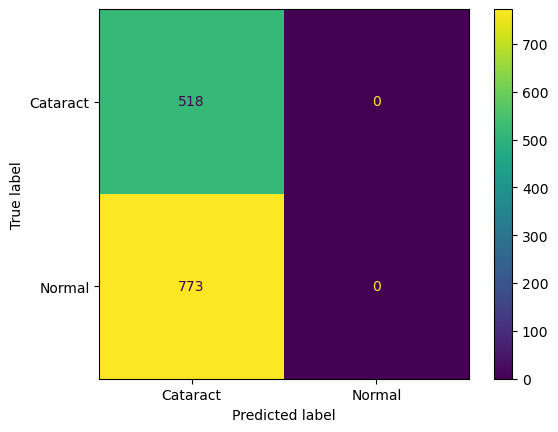

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cataract_detection_model = load_model('cataractdetectionmodel.h5')

prediction_cataract_model = cataract_detection_model.predict(cataract_test_generator) 
cataract_model_classes=np.argmax(prediction_cataract_model,axis=1)

test_loss, test_accuracy = cataract_detection_model.evaluate(cataract_test_generator)

cataract_matrix = confusion_matrix(cataract_test_generator.classes, cataract_model_classes)


print("Test Accuracy")
print(test_accuracy)

print("Confusion Matrix:")

cm_display = ConfusionMatrixDisplay(confusion_matrix = cataract_matrix, display_labels = ["Cataract", "Normal"])
cm_display.plot()
plt.show()


17/17 [==============================] - 55s 3s/step - loss: 0.5610 - accuracy: 0.8127
Test Accuracy
0.8127413392066956
Confusion Matrix:


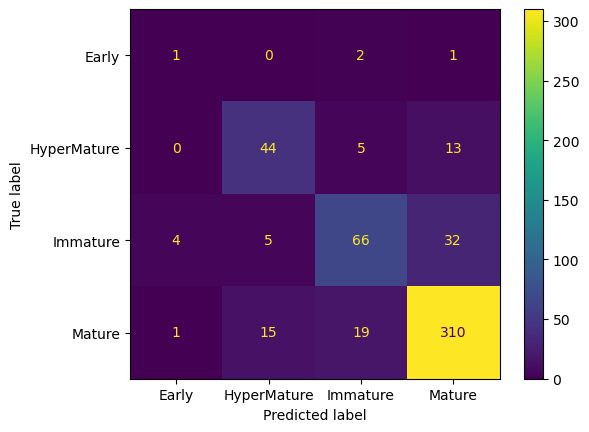

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


ensemble_model = load_model('ensembleModelv2.h5')

prediction_ensemble_model = ensemble_model.predict(test_generator) 
ensemble_model_classes=np.argmax(prediction_ensemble_model,axis=1)

test_loss, test_accuracy = ensemble_model.evaluate(test_generator)

ensemble_matrix = confusion_matrix(test_generator.classes, ensemble_model_classes)


print("Test Accuracy")
print(test_accuracy)

print("Confusion Matrix:")

cm_display = ConfusionMatrixDisplay(confusion_matrix = ensemble_matrix, display_labels = ["Early", "HyperMature", "Immature", "Mature"])
cm_display.plot()
plt.show()

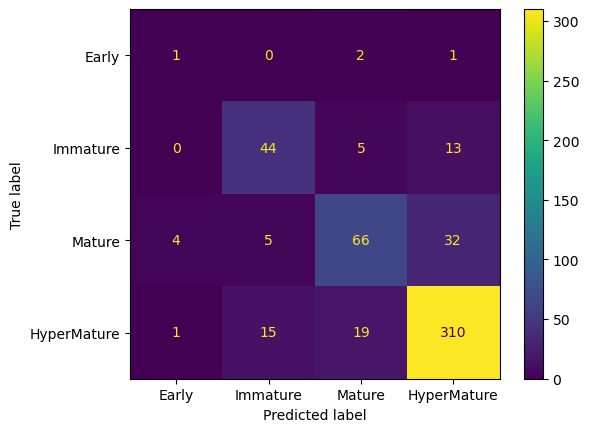

In [47]:
import glob
class_names = []
for directory in glob.glob(cataract_train_path + "/*"):
    label = os.path.basename(os.path.normpath(directory))
    class_names.append(label)

print(class_names)

['Cataract', 'Normal']


In [46]:
import glob
multiclass_names = []
for directory in glob.glob(cataract_severity_train_path + "/*"):
    label = os.path.basename(os.path.normpath(directory))
    multiclass_names.append(label)

print(multiclass_names)

['Early Stage', 'HyperMature Stage', 'Immature Stage', 'Mature Stage']


In [ ]:
from keras.models import load_model
cataract_model = load_model('cataractdetectionmodel.h5')
ensemble_model = load_model('ensembleModelv2.h5')

1/1 [==============================] - 0s 148ms/step
Prediction
Predicted Label: Cataract
Predicted Label: Immature Stage


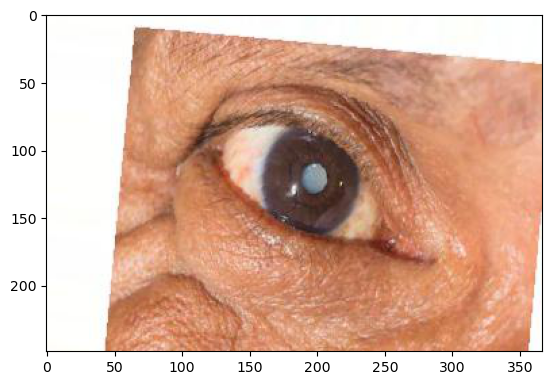

In [70]:
def predict_image(image_path) : 
    img = load_img(image_path, target_size=(224, 224))
    if img is not None :                      
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) 
        img_array /= 255.  
        
        result1 = cataract_model.predict(img_array)
        result1 = np.argmax(result1,axis=1)

        result2 = ensemble_model.predict(img_array)
        result2 = multiclass_names[int(np.argmax(result2,axis=1))]

        print("Prediction")

        print("Predicted Label: " + class_names[int(result1[0])])  
        print("Predicted Label: " + result2)

        

image_path = "C:\\Users\\Sadu Ravi\\Desktop\\cat_0_9993.jpg"     
image = plt.imread(image_path)
plt.imshow(image, cmap='gray')
predict_image(image_path)